In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

2024-04-16 22:29:13.215221: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
nl_df = pd.read_csv('/Users/lpaggen/Documents/DACS COURSES/Project2-2/Project_2-2/test_nl/processed_data.csv')

In [30]:
nl_df.head()

,time,latitude,longitude,surface,u10,v10,d2m,t2m,sp,tcc,...,month_7,month_8,month_9,month_10,month_11,month_12,hour_0,hour_6,hour_12,hour_18
0,2017-01-01 00:00:00,53.5,3.50,0.0,9.154511,5.653595,280.33643,281.26220,101953.44,0.777771,...,False,False,False,False,False,False,True,False,False,False
1,2017-01-01 00:00:00,53.5,3.75,0.0,9.359589,5.501251,280.34814,281.41260,101958.44,0.768646,...,False,False,False,False,False,False,True,False,False,False
2,2017-01-01 00:00:00,53.5,4.00,0.0,9.572479,5.372345,280.37354,281.57470,101969.44,0.768829,...,False,False,False,False,False,False,True,False,False,False
3,2017-01-01 00:00:00,53.5,4.25,0.0,9.634003,5.183868,280.34814,281.67627,101984.44,0.666290,...,False,False,False,False,False,False,True,False,False,False
4,2017-01-01 00:00:00,53.5,4.50,0.0,9.669159,4.993439,280.31300,281.75244,101994.44,0.612579,...,False,False,False,False,False,False,True,False,False,False


In [31]:
ams_df = nl_df[(nl_df['latitude'] == 52.25) & (nl_df['longitude'] == 5.)]

In [32]:
ams_df = ams_df.sort_values(by = ['time'])

In [33]:
ams_df = ams_df.set_index('time')

In [34]:
ams_df = ams_df.drop(['latitude', 'longitude', 'surface', 'step', 'number', 'valid_time'], axis = 1)

Text(0, 0.5, 'temperature (K)')

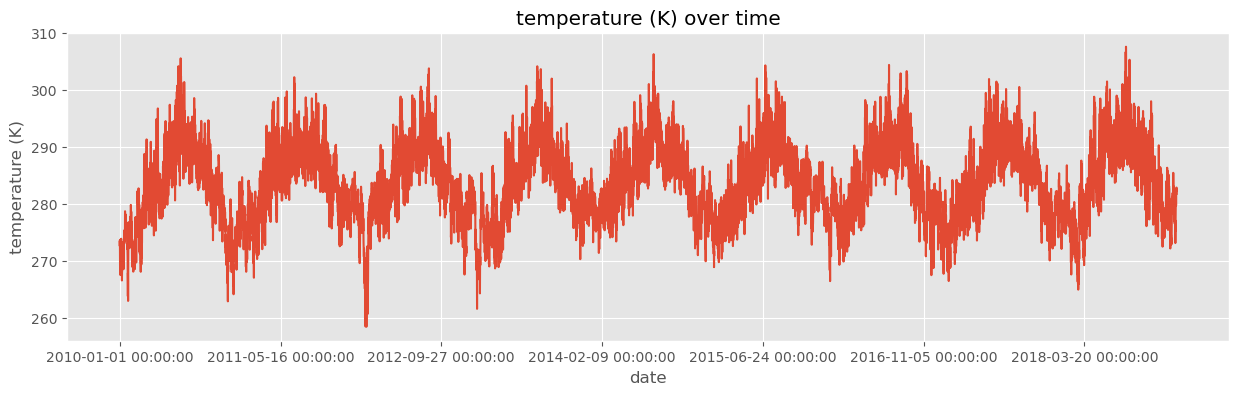

In [35]:
# some error in the plot -> probably due to large number of observations ?

plt.style.use('ggplot')
plt.figure(figsize = (15, 4))
ams_df['t2m'].plot(label = 'date', title = "temperature (K) over time")
plt.xlabel('date')
plt.ylabel('temperature (K)')

In [36]:
# this just moves temp to the right of the DF, easier for X / y split

ams_df['temp'] = ams_df['t2m']
ams_df = ams_df.drop(['t2m'], axis = 1)

In [37]:
# this does the train test split, prints the dimensions too

train_split = round(len(ams_df) * 0.8)
ams_df_tra = ams_df.iloc[:train_split, :]
ams_df_tst = ams_df.iloc[train_split:, :]
print(ams_df_tra.shape)
print(ams_df_tst.shape)

(10518, 22)
(2630, 22)


In [39]:
# scales data, necessary for LSTM

scaler = MinMaxScaler(feature_range=(0,1))
ams_df_tst_scaled = scaler.fit_transform(ams_df_tra)
ams_df_tra_scaled = scaler.transform(ams_df_tst)

In [40]:
# found this online, basically gets data in 3d format i think? (3d involves timestep)

def createXY(dataset, n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, :-1])
            dataY.append(dataset[i, -1])
    return np.array(dataX),np.array(dataY)

X_train, Y_train = createXY(ams_df_tra_scaled, 30)
X_test, Y_test = createXY(ams_df_tst_scaled, 30)

In [46]:
print(X_train.shape[1])
print(X_train.shape[2])

30
21


In [47]:
# now using keras we make the LSTM

model = Sequential()
model.add(LSTM(units = 50, input_shape = (X_train.shape[1], X_train.shape[2]))) # input shape -> (None, timestep, features) -> 3D (?)
model.add(Dense(units = 1))

# use adam (can use other, idk what that even is) / MSE (maybe look at cross-entropy instead)
model.compile(optimizer='adam', loss='mse')

# fit model
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test), shuffle=False)

# evaluate model
loss = model.evaluate(X_test, Y_test)

# predictions 
predictions = model.predict(X_test)

2024-04-16 22:51:34.444534: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
82/82 [==============================] - 2s 19ms/step - loss: 0.0523 - val_loss: 0.0356
Epoch 2/50
82/82 [==============================] - 1s 16ms/step - loss: 0.0224 - val_loss: 0.0819
Epoch 3/50
82/82 [==============================] - 1s 16ms/step - loss: 0.0206 - val_loss: 0.0113
Epoch 4/50
82/82 [==============================] - 1s 16ms/step - loss: 0.0079 - val_loss: 0.0059
Epoch 5/50
82/82 [==============================] - 1s 16ms/step - loss: 0.0052 - val_loss: 0.0069
Epoch 6/50
82/82 [==============================] - 1s 16ms/step - loss: 0.0051 - val_loss: 0.0064
Epoch 7/50
82/82 [==============================] - 1s 16ms/step - loss: 0.0045 - val_loss: 0.0051
Epoch 8/50
82/82 [==============================] - 1s 16ms/step - loss: 0.0045 - val_loss: 0.0074
Epoch 9/50
82/82 [==============================] - 1s 17ms/step - loss: 0.0050 - val_loss: 0.0109
Epoch 10/50
82/82 [==============================] - 1s 16ms/step - loss: 0.0063 - val_loss: 0.0082
Epoch 11/

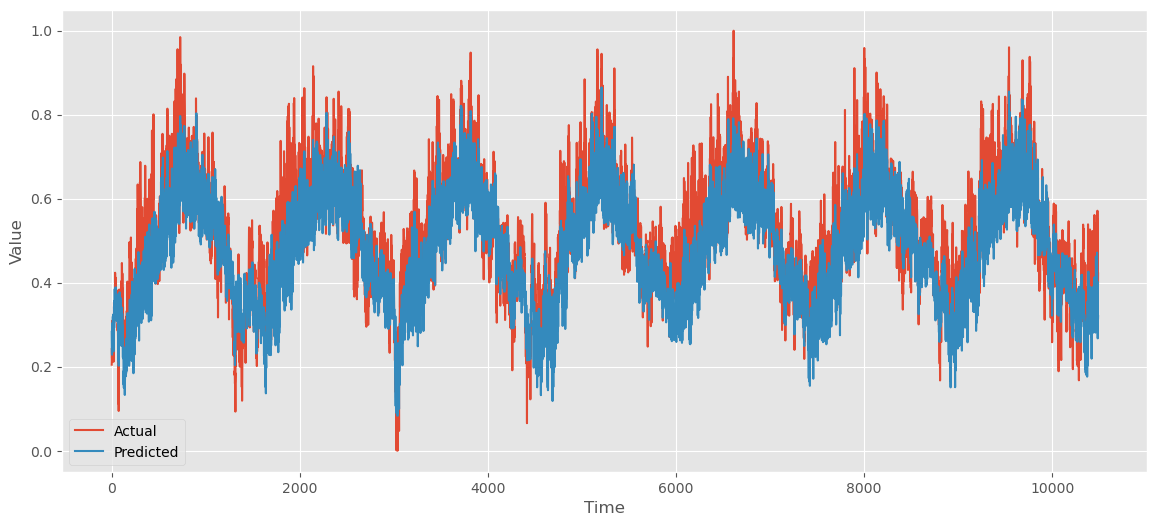

In [49]:
plt.figure(figsize = (14, 6))

# plot observed temperature
plt.plot(Y_test, label='Actual')

# plot predicted temperature
plt.plot(predictions, label='Predicted')

plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()